In [1]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
from sklearn.neighbors import KernelDensity

In [25]:
%matplotlib inline

## Read

In [9]:
tweets = pd.read_csv('data/tokyo-200k-tweets-followthehashtag.csv')

In [10]:
tweets = tweets[[
    'Date',
    'Hour',
    'Latitude',
    'Longitude'
]].dropna()

In [11]:
tweets = tweets.rename(columns={
    'Latitude': 'lat',
    'Longitude': 'lon',
})

In [12]:
# TODO: hour of day and day of week are cyclical, for social phenomena, but not for weather

## Preprocess

### Date

In [13]:
tweets['datetime'] = pd.to_datetime(tweets.Date + ' ' + tweets.Hour)
tweets = tweets.drop(['Date', 'Hour'], axis=1)

In [14]:
tweets.datetime += pd.Timedelta(hours=-13)

In [15]:
tweets['timestamp'] = tweets.datetime.astype(int) // 10**9

Timezone correction: align the gap with [tweets stats reported distribution](https://twittertoolsbook.com/wp-content/uploads/2011/03/tweet-stats.png)

In [16]:
# date
tweets['day'] = tweets.datetime.map(lambda d: d.weekday())
tweets['hour'] = tweets.datetime.map(lambda d: d.hour)

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

## Model

In [27]:
%%time
kde = KernelDensity(bandwidth=.1)
kde.fit(tweets[['lat', 'lon', 'timestamp']])

CPU times: user 2.54 s, sys: 8.26 ms, total: 2.55 s
Wall time: 2.55 s


---

In [28]:
lat_range = np.linspace(
    tweets.lat.quantile(.5), 
    tweets.lat.quantile(.95),
    10,
)
lon_range = np.linspace(
    tweets.lon.quantile(.5), 
    tweets.lon.quantile(.95),
    10,
)

timestamp_range = np.linspace(
    tweets.timestamp.min(),
    tweets.timestamp.max(),
    20
)

In [29]:
grids = np.meshgrid(lat_range, lon_range, timestamp_range)
raveled_grids = [g.ravel() for g in grids]

In [30]:
grid_stacked = np.vstack(raveled_grids).T

In [31]:
len(grid_stacked)

2000

In [32]:
%%time
estimations = np.exp(kde.score_samples(grid_stacked))

CPU times: user 963 ms, sys: 3.94 ms, total: 967 ms
Wall time: 964 ms


In [33]:
result = pd.DataFrame([*raveled_grids, estimations]).T
result.columns = ['lat', 'lon', 'timestamp', 'count_estimation']

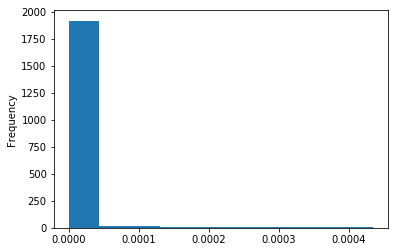

In [34]:
result.count_estimation.plot('hist')

In [220]:
result.count_estimation.describe()

count     1.350000e+05
mean      3.154673e-07
std       1.515238e-06
min       0.000000e+00
25%      1.565657e-317
50%      1.897107e-121
75%       3.449155e-24
max       1.287979e-05
Name: count_estimation, dtype: float64

In [236]:
(result.count_estimation > 0).mean()

0.762962962962963

In [ ]:
result[result]

---

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
X = tweets.hour.values.reshape(-1, 1)
x = np.linspace(0, 24, 100)[:, np.newaxis]

In [ ]:
# TODO not bucketize, convert into percentages of day, and percentage of week
# TODO kde but repeat before and after so it doesn't end abruptly, because of the cyclicity

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=1, leaf_size=20).fit(X)
log_dens = kde.score_samples(x)
plt.plot(x[:, 0], np.exp(log_dens))